# 4. 本番環境へのリリース

ステージング環境で動作確認ができたら、承認ボタンを押して本番リリースをしましょう！

## 4.1. パイプラインの改変

インフラ環境更新に必要な設定値をローカルファイルに追記します。

In [ ]:
cat << EOT >> ~/config/.env
export PRODUCTION_STACK_NAME="fargate-handson-production-env"
EOT

Staging 環境のリソース定義に [この](/edit/infrastructure/diff/production) パッチをあてます。

In [ ]:
patch ~/notebook/infrastructure/sam.yaml < ~/notebook/infrastructure/diff/production

適用前に、新しい sam.yaml の内容が正しいことを検証します。

In [ ]:
aws cloudformation validate-template --template-body file://infrastructure/sam.yaml

成功時応答例）
```text
{
    "Description": "A fargate application with a CI/CD pipeline",
    "Parameters": [
        {
            "ParameterKey": "ProjectID",
            "NoEcho": false
        },
    ..
```

Lambda 関数を含むテンプレートのため、パッケージングします。

In [ ]:
source ~/config/.env

aws cloudformation package \
    --template-file infrastructure/sam.yaml \
    --output-template-file infrastructure/cfn.yaml \
    --s3-bucket "${S3_BUCKET_NAME}" \
    --s3-prefix "cloudformation"

成功時応答）
```text
Uploading to cloudformation/0e64849e597b443d9a1349275098ab43  766 / 766.0  (100.00%)
Successfully packaged artifacts and wrote output template to file infrastructure/cfn.yaml
..
```

パッケージングした CloudFormation テンプレートでインフラを更新します。

In [ ]:
aws cloudformation deploy \
    --stack-name "${BASE_STACK_NAME}" \
    --template-file infrastructure/cfn.yaml \
    --parameter-overrides \
        ProjectID="${PROJECT_ID}" \
        S3BucketName="${S3_BUCKET_NAME}" \
        EdgeStackName="${EDGE_STACK_NAME}" \
        StagingStackName="${STAGING_STACK_NAME}" \
        ProductionStackName="${PRODUCTION_STACK_NAME}" \
        ApprovalEmail="${GIT_EMAIL_ADDRESS}" \
    --capabilities CAPABILITY_IAM

成功時応答）
```text
Waiting for changeset to be created..
Waiting for stack create/update to complete
Successfully created/updated stack - fargate-handson-base
```

## 4.2. 本番環境の Fargate を起動する

ステージングと同様のテンプレートを使い、本番環境を作成します。

In [ ]:
DOCKER_IMAGE=dockercloud/hello-world

aws cloudformation deploy \
    --stack-name "${PRODUCTION_STACK_NAME}" \
    --template-file application/deploy/cfn-release.yaml \
    --parameter-overrides \
        ProjectID="${PROJECT_ID}" \
        DockerImage="${DOCKER_IMAGE}" \
    --capabilities CAPABILITY_IAM

成功時応答）
```text
Waiting for changeset to be created..
Waiting for stack create/update to complete
Successfully created/updated stack - fargate-handson-production-env
```

構築が完了したら、本番環境の Fargate を確認してみましょう。

In [ ]:
PRODUCTION_ENDPOINT="http://$( aws cloudformation describe-stacks \
    --stack-name "${PRODUCTION_STACK_NAME}" --output text \
    --query 'Stacks[*].Outputs[?OutputKey==`LoadBalancerDNSName`].OutputValue' )"

cat << EOT >> ~/config/.env
export PRODUCTION_ENDPOINT="${PRODUCTION_ENDPOINT}"
EOT
echo "${PRODUCTION_ENDPOINT}"

応答例）
```text
http://farga-LoadB-xxx-xxx.ap-northeast-1.elb.amazonaws.com
```

## 4.3 開発〜本番までのリリースをおさらいする

master ブランチに変更が入り、Edge / Staging と確認していき、Production へとリリースしていきます。

### 4.3.1. アプリケーションを作成、master へ push

最後に AWS の API を利用した Web サービスをリリースしてみましょう。

アプリケーションが内部的に **新しい AWS の権限を必要とする** 場合、[TaskRole に割り当てて](/edit/application/diff/iam.yaml)おきます。

In [ ]:
cd ~/notebook/application

patch deploy/cfn-master.yaml < diff/iam.yaml
patch deploy/cfn-release.yaml < diff/iam.yaml

正常時応答）
```text
patching file deploy/cfn-master.yaml
patching file deploy/cfn-release.yaml
```

Edge 環境と Staging 環境についてはこれまで同様のパスワードを振っておきます。

In [ ]:
cat << EOT > deploy/edge/env.sh
export BASIC_AUTH="BasicAuthUsername":"edge","BasicAuthPassword":"fargate"
EOT
chmod +x deploy/edge/env.sh
cat << EOT > deploy/staging/env.sh
export BASIC_AUTH="BasicAuthUsername":"staging","BasicAuthPassword":"fargate"
EOT
chmod +x deploy/staging/env.sh

Go 言語でアプリケーションを [書いたとします](/edit/application/main.go)。  
それをビルドするため、**Dockerfile** も書き換えます。

In [ ]:
cat << EOF > Dockerfile
FROM golang:1.10-alpine3.8 AS build-env
ADD .   /go/src/app/
WORKDIR /go/src/app/
RUN apk --no-cache add git \\
    && go get -u github.com/golang/dep/cmd/dep \\
    && dep ensure \\
    && go build -ldflags "-s -w"

FROM alpine:3.8
RUN apk add --no-cache ca-certificates
COPY --from=build-env /go/src/app/app /usr/local/bin/app
ENTRYPOINT ["app"]
EOF

master ブランチに push しましょう。

In [ ]:
git add .
git commit -m "implement a web service using aws translate"
git push

応答例）
```text
[master 487af80] implement a web service using aws translate
 3 files changed, 2498 insertions(+), 19 deletions(-)
 create mode 100644 Gopkg.lock
 create mode 100644 Gopkg.toml
..
```

開発（Edge）環境のパイプラインが動き、環境が更新されます。  
内容が正しいか確認しましょう。

In [ ]:
codebuild_project_name=$( aws cloudformation describe-stacks \
    --stack-name "${BASE_STACK_NAME}" --output text \
    --query 'Stacks[*].Outputs[?OutputKey==`CodePipeline`].OutputValue' )
codebuild_console="https://ap-northeast-1.console.aws.amazon.com/codepipeline/home"
echo "${codebuild_console}?region=${AWS_DEFAULT_REGION}#/view/${codebuild_project_name}"

In [ ]:
cluster_name=$( aws cloudformation describe-stacks \
    --stack-name "${EDGE_STACK_NAME}" --output text \
    --query 'Stacks[*].Outputs[?OutputKey==`Cluster`].OutputValue' )
task_id=$( aws ecs list-tasks --cluster "${cluster_name}" \
    --family "${EDGE_STACK_NAME}" | jq -r '.taskArns[0]' )
eni_id=$( aws ecs describe-tasks --cluster "${cluster_name}" --task "${task_id}" \
    | jq '.tasks[0].attachments[0].details[]' \
    | jq -r 'select( .name | contains("networkInterfaceId")).value' )
edge_endpoint="http://$( aws ec2 describe-network-interfaces \
    --network-interface-ids ${eni_id} \
    | jq -r '.NetworkInterfaces[].Association.PublicIp' )"

echo "${edge_endpoint}"

Basic 認証は変わらずユーザー名は **edge**、パスワードは **fargate** です。

以下のような画面か返ってきたら OK です！
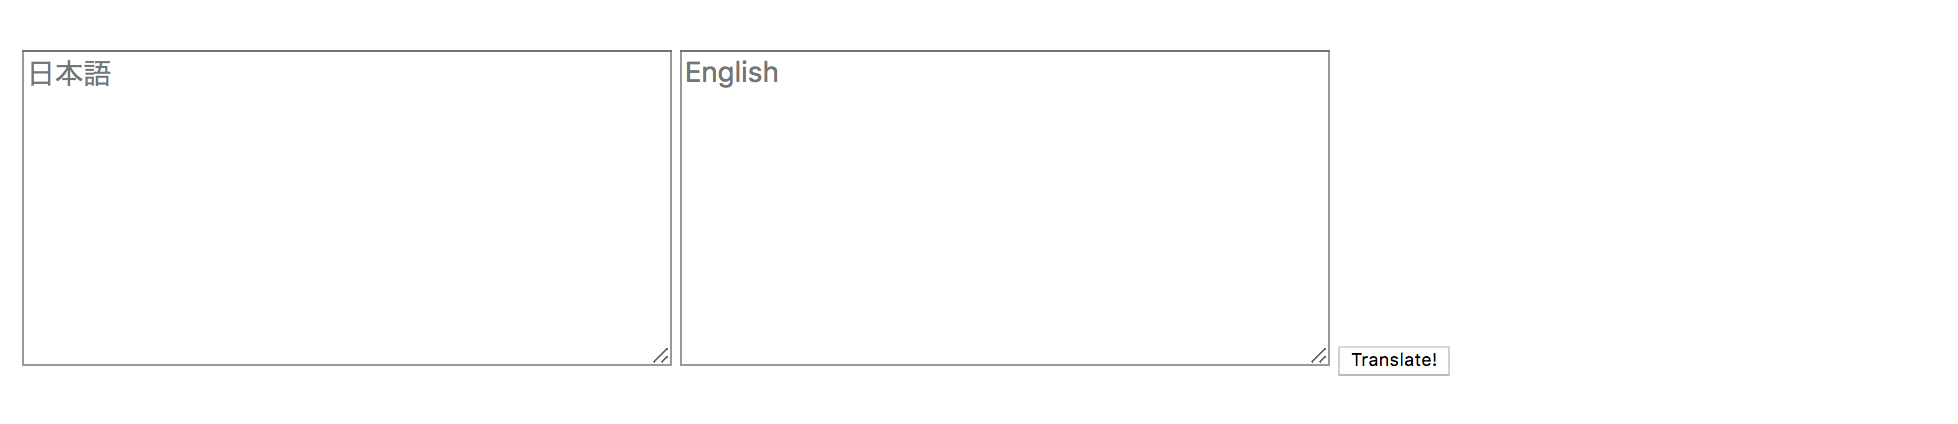

### 4.3.2. release ブランチへのマージ、staging 環境での確認

Edge 環境で動作確認が取れたら、release ブランチに対してプルリクエストを作成します。

In [ ]:
repo="fargate-handson"
aws codecommit create-pull-request \
    --title "Implemented v1.0 features" \
    --description "Please check ASAP :)" \
    --targets "repositoryName=${repo},sourceReference=master,destinationReference=release"

応答例）
```text
{
    "pullRequest": {
        "pullRequestId": "2",
        "title": "Implemented v1.0 features",
        "description": "Please check ASAP :)",
        "pullRequestTargets": [
            {
                "repositoryName": "fargate-handson",
                "sourceReference": "refs/heads/master",
                "destinationReference": "refs/heads/release",
    ..
}
```

今回も仕方ありません。自分でレビューをしてマージしましょう・・  
https://ap-northeast-1.console.aws.amazon.com/codecommit/home?region=ap-northeast-1#/repository/fargate-handson/pull-requests

release ブランチにマージされると、ステージング環境へのデプロイが開始されます。

In [ ]:
codebuild_project_name=$( aws cloudformation describe-stacks \
    --stack-name "${BASE_STACK_NAME}" --output text \
    --query 'Stacks[*].Outputs[?OutputKey==`CodePipelineRelease`].OutputValue' )
codebuild_console="https://ap-northeast-1.console.aws.amazon.com/codepipeline/home"
echo "${codebuild_console}?region=${AWS_DEFAULT_REGION}#/view/${codebuild_project_name}"

`DeployToStaging` まで完了、またはデプロイ通知のメールが来たら、  
ステージング環境でも内容が変更されたことを確認してみましょう。

In [ ]:
echo "${STAGING_ENDPOINT}"

Basic 認証のユーザー名は **staging**、パスワードは **fargate** です。

開発環境同様の画面は見えましたか？

### 4.3.3. 本番環境へのリリース

本番環境へのデプロイが準備されると、git ユーザーのメールアドレスに対して  
`本番環境へのリリースを承認する` アクションを要求するメールが届きます。  
リンクをクリックして承認画面に進みましょう。
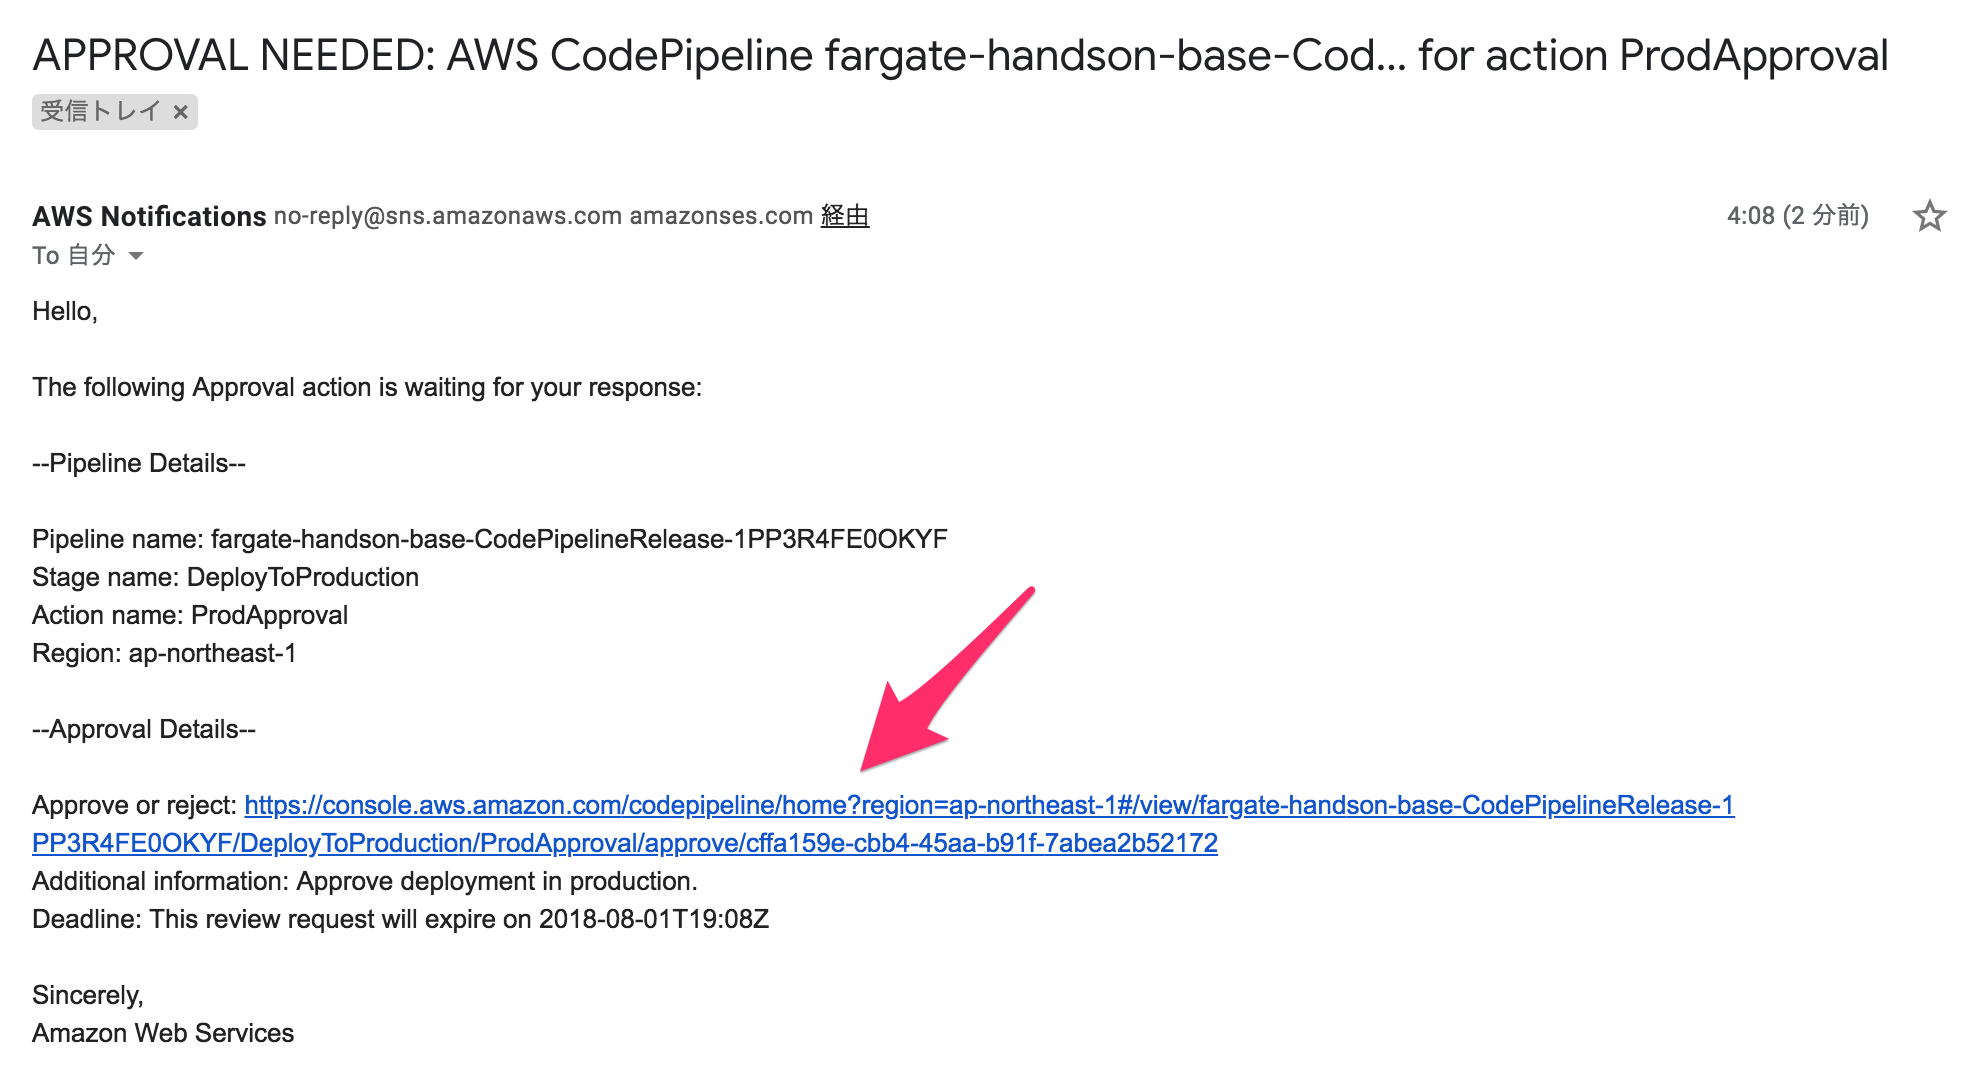

理由を書き `Approve` するとデプロイ処理が再開します。  
処理が最後まで進み、Production へのデプロイが完了した旨のメールが来たら、実際の環境を確認してみましょう！

In [ ]:
PRODUCTION_ENDPOINT="http://$( aws cloudformation describe-stacks \
    --stack-name "${PRODUCTION_STACK_NAME}" --output text \
    --query 'Stacks[*].Outputs[?OutputKey==`LoadBalancerDNSName`].OutputValue' )"
echo "${PRODUCTION_ENDPOINT}"

他の 2 環境同様の画面が表示されれば本番環境へのリリースは完了です！  
[次へ: 05-teardown-resources.ipynb](05-teardown-resources.ipynb)